# Кейс - Приложение знакомств

Вы работаете аналитиком в приложении для онлайн-знакомств. Механика приложения следующая: пользователи видят в приложении анкеты друг друга и могут ставить друг другу лайки или дизлайки. Если пользователи поставили друг другу лайк – это называется мэтч, и у пользователей появляется возможность познакомиться.

Команда приложения разработала новый алгоритм для поиска наиболее подходящих анкет. Для проверки работы алгоритма был проведен АБ-тест. Все пользователи были разделены на две группы. Пользователи в группе с номером 0 пользовались приложением со старым алгоритмом. Все пользователи в группе 1 пользовались приложением с новым алгоритмом для поиска анкет.

Ваша задача – оценить, правда ли, что новый алгоритм улучшил качество сервиса. Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.

В данных находится выгрузка логов взаимодействия пользователей друг с другом. Для каждой пары пользователей указано, из какой они группы АБ-теста и случился ли у них мэтч.

Результат вашей работы – аналитическое заключение с ответом на вопрос, стоит ли включать новую систему поиска анкет на всех пользователей.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import pingouin as pg

import seaborn as sns
import matplotlib.pyplot as plt

import requests
from urllib.parse import urlencode

In [2]:
def url_ydisk (url):
    
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    public_key = url

    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']

    return download_url

In [3]:
# Чтение данных
df = pd.read_csv(url_ydisk('https://disk.yandex.ru/d/txn7q-CE2zSaPg'))
df.head()

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1


In [4]:
df.isna().sum()

user_id_1    0
user_id_2    0
group        0
is_match     0
dtype: int64

In [5]:
df.nunique()

user_id_1    1000
user_id_2    1000
group           2
is_match        2
dtype: int64

In [6]:
df.dtypes

user_id_1    int64
user_id_2    int64
group        int64
is_match     int64
dtype: object

In [7]:
df.duplicated().sum()

0

In [8]:
df.describe()

,user_id_1,user_id_2,group,is_match
count,14514.000000,14514.000000,14514.000000,14514.000000
mean,500.220132,501.843737,0.669836,0.333678
std,288.703825,287.250879,0.470288,0.471542
min,1.000000,1.000000,0.000000,0.000000
25%,253.000000,255.000000,0.000000,0.000000
50%,504.000000,500.000000,1.000000,0.000000
75%,751.000000,752.750000,1.000000,1.000000
max,1000.000000,1000.000000,1.000000,1.000000


### Метрики
Основная метрика — бинарная переменная is_match, которая указывает на то, произошел ли мэтч между пользователями.

Для анализа использую коэффициент мэтча по группам.

In [9]:
# Подсчет количества мэтчей и пользователей в каждой группе 
# df.query('group == 0').is_match.sum() / df.query('group == 0').is_match.shape[0]

match_rate = df.groupby('group')['is_match'].mean().reset_index()
match_rate

,group,is_match
0,0,0.194908
1,1,0.402078


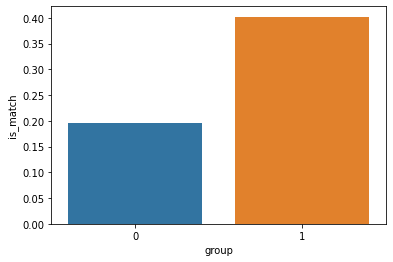

In [10]:
# Построение графика распределения мэтчей по группам
sns.barplot(x='group', y='is_match', data=match_rate)

In [11]:
control = df.query('group == 0').is_match
test = df.query('group == 1').is_match

Чтобы выбрать стат тест, проведем тест на нормальность распределений переменных.

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


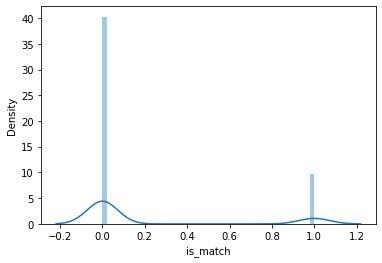

In [12]:
sns.distplot(control)

In [13]:
print(ss.normaltest(control))
print(ss.normaltest(test))

NormaltestResult(statistic=1056.7389057083074, pvalue=3.4045696177523702e-230)
NormaltestResult(statistic=37375.72668370961, pvalue=0.0)


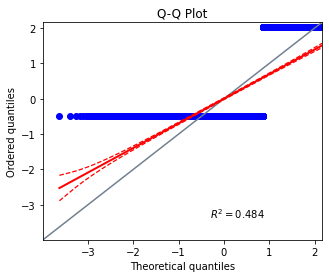

In [14]:
pg.qqplot(control)

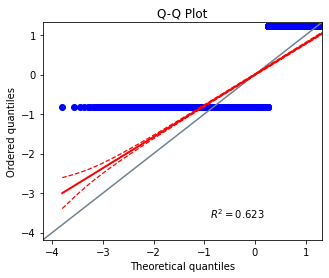

In [15]:
pg.qqplot(test)

В ходе неоднократной проверки пришли к выводу, что переменные распределены ненормально.

Имеем две дискретные переменные (control/test), рапределение которых ненормально → нужен критерий Манна-Уитни

- $H_0$: Распределения переменной is_match для двух групп равны.
- $H_1$: Распределения переменной is_match для двух групп не равны.

In [16]:
# Проведение теста Манна-Уитни
u_stat, p_value = ss.mannwhitneyu(control, test)
u_stat, p_value

(18468122.0, 9.239398092772123e-137)

In [17]:
p_value < 0.05 

True

**Вывод:** p-value < 0.05 → существует статистически значимое различие между группами.

Следовательно новый алгоритм эффективен - новую систему поиска анкет на всех пользователей стоит включить.